In [1]:
import time
import numpy as np

import mss
import cv2
from PIL import Image

import matplotlib.pyplot as plt

from xpc3 import *
from xpc3_helper_sm import *

In [2]:
client = XPlaneConnect()
reset(client, dtpInit=322.0)

In [3]:
bottom_left = [37.077147, -121.594214]
top_left = [37.077065, -121.594450]
bottom_right = [37.086130, -121.599148]
top_right = [37.086047, -121.599384]

In [4]:
def put_on_ground(client):
    curr_agly = client.getDREF("sim/flightmodel/position/y_agl")[0]
    curr_localy = client.getDREF("sim/flightmodel/position/local_y")[0]
    client.sendDREF("sim/flightmodel/position/local_y",
                    curr_localy - curr_agly)

In [8]:
client.sendPOSI(bottom_right)
time.sleep(0.5)
put_on_ground(client)

# Get X-Plane Coordinates for Corners

In [9]:
client.sendPOSI(bottom_left)
time.sleep(0.5)
put_on_ground(client)

x = client.getDREF("sim/flightmodel/position/local_x")[0]
y = client.getDREF("sim/flightmodel/position/local_y")[0]
z = client.getDREF("sim/flightmodel/position/local_z")[0]

bl = [x, y, z]

In [10]:
client.sendPOSI(top_left)
time.sleep(0.5)
put_on_ground(client)

x = client.getDREF("sim/flightmodel/position/local_x")[0]
y = client.getDREF("sim/flightmodel/position/local_y")[0]
z = client.getDREF("sim/flightmodel/position/local_z")[0]

tl = [x, y, z]

In [11]:
client.sendPOSI(bottom_right)
time.sleep(0.5)
put_on_ground(client)

x = client.getDREF("sim/flightmodel/position/local_x")[0]
y = client.getDREF("sim/flightmodel/position/local_y")[0]
z = client.getDREF("sim/flightmodel/position/local_z")[0]

br = [x, y, z]

In [103]:
client.sendPOSI(top_right)
time.sleep(0.5)
put_on_ground(client)

x = client.getDREF("sim/flightmodel/position/local_x")[0]
y = client.getDREF("sim/flightmodel/position/local_y")[0]
z = client.getDREF("sim/flightmodel/position/local_z")[0]

tr = [x, y, z]

In [104]:
getHomeState(client)

(-11.144431726615903, -23.464566525155607, -6.103515630684342e-06)

In [14]:
print(bl)
print(tl)
print(br)
print(tr)

[36039.34765625, -191.1477813720703, 46994.19921875]
[36018.3671875, -191.0932159423828, 47003.61328125]
[35596.71875, -178.7970733642578, 45996.453125]
[35576.4296875, -178.77920532226562, 46005.45703125]


# Plot Runway Points

In [15]:
bl = [36039.34765625, -191.1477813720703, 46994.19921875]
tl = [36018.3671875, -191.0932159423828, 47003.61328125]
br = [35596.71875, -178.7970733642578, 45996.453125]
tr = [35576.4296875, -178.77920532226562, 46005.45703125]

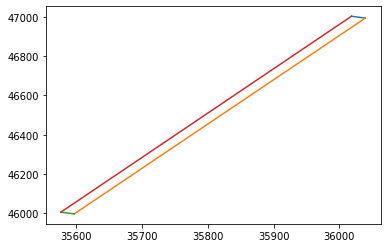

In [16]:
plt.plot([bl[0], tl[0]], [bl[2], tl[2]])
plt.plot([bl[0], br[0]], [bl[2], br[2]])
plt.plot([br[0], tr[0]], [br[2], tr[2]])
plt.plot([tl[0], tr[0]], [tl[2], tr[2]])

# Project runway corners into image

In [30]:
setHomeState(client, 0, 15, 180)

In [31]:
screen_shot = mss.mss()
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]

In [32]:
sh, sw, _ = ss.shape

In [33]:
mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T
proj = np.reshape(client.getDREF("sim/graphics/view/projection_matrix_3d"), (4, 4)).T

In [34]:
def get_image_coord(pt, mv, proj, sh, sw):
    pt_h = np.append(np.array(pt), 1.0)
    pt_eye = mv @ pt_h
    pt_ndc = proj @ pt_eye
    pt_ndc = pt_ndc[:3] / pt_ndc[3]
    xp = sw * (pt_ndc[0] * 0.5 + 0.5)
    yp = sh - sh * (pt_ndc[1] * 0.5 + 0.5)
    return xp, yp

In [35]:
br_shifted = [br[0], br[1] - 1.75, br[2]]
tr_shifted = [tr[0], tr[1] - 1.75, tr[2]]
bl_shifted = [bl[0], bl[1] - 1.75, bl[2]]
tl_shifted = [tl[0], tl[1] - 1.75, tl[2]]

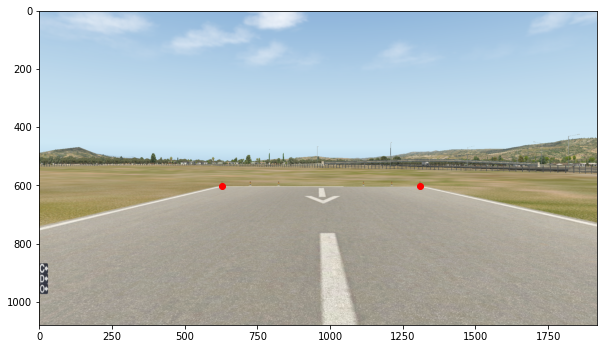

In [36]:
plt.figure(figsize=(10, 6))
xp1, yp1 = get_image_coord(tr_shifted, mv, proj, sh, sw)
xp2, yp2 = get_image_coord(br_shifted, mv, proj, sh, sw)
plt.imshow(ss)
plt.scatter([xp1, xp2], [yp1, yp2], c='red')

# Figure Out Reference Points

In [37]:
dtps = np.arange(0, 1050, 10)
ys = []
for dtp in dtps:
    setHomeState(client, 0, dtp, 0)
    time.sleep(0.25)
    ys.append(client.getDREF("sim/flightmodel/position/local_y")[0])

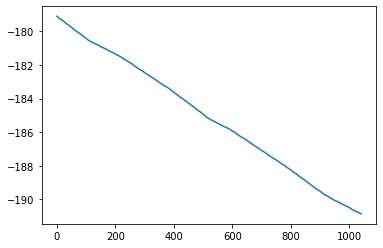

In [38]:
plt.plot(dtps, ys)

In [44]:
def get_pixels(line, sw):
    a, b, c = line
    xs = np.arange(0, sw, 1)
    ys = [-(a / b) * x + (-c / b) for x in xs]
    return xs, ys

In [45]:
def get_image_coord(pt, sh, sw):
    mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T
    proj = np.reshape(client.getDREF(
        "sim/graphics/view/projection_matrix_3d"), (4, 4)).T

    pt_h = np.append(np.array(pt), 1.0)
    pt_eye = mv @ pt_h
    pt_ndc = proj @ pt_eye
    pt_ndc = pt_ndc[:3] / pt_ndc[3]
    xp = sw * (pt_ndc[0] * 0.5 + 0.5)
    yp = sh - sh * (pt_ndc[1] * 0.5 + 0.5)
    return xp, yp

In [102]:
setHomeState(client, 0, 250, 0)
time.sleep(0.2)
screen_shot = mss.mss()
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]
sh, sw, _ = ss.shape

(-0.5, 1919.5, 1079.5, -0.5)

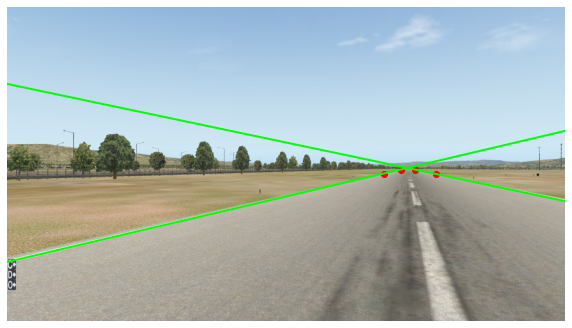

In [98]:
alpha1 = 0.2
alpha2 = 0.6
shift = 1.85
pt1 = alpha1 * np.array(br) + (1 - alpha1) * np.array(bl)
pt2 = alpha2 * np.array(br) + (1 - alpha2) * np.array(bl)
pt1_shifted = pt1 - np.array([0.0, shift, 0.0])
pt2_shifted = pt2 - np.array([0.0, shift, 0.0])
pt3 = alpha1 * np.array(tr) + (1 - alpha1) * np.array(tl)
pt4 = alpha2 * np.array(tr) + (1 - alpha2) * np.array(tl)
pt3_shifted = pt3 - np.array([0.0, shift, 0.0])
pt4_shifted = pt4 - np.array([0.0, shift, 0.0])
x1, y1 = get_image_coord(pt1_shifted, sh, sw)
x2, y2 = get_image_coord(pt2_shifted, sh, sw)
x3, y3 = get_image_coord(pt3_shifted, sh, sw)
x4, y4 = get_image_coord(pt4_shifted, sh, sw)
line1 = np.cross(np.array([x1, y1, 1]), np.array([x2, y2, 1]))
xs1, ys1 = get_pixels(line1, sw)
line2 = np.cross(np.array([x3, y3, 1]), np.array([x4, y4, 1]))
xs2, ys2 = get_pixels(line2, sw)
plt.figure(figsize=(10, 6))
plt.imshow(ss)
plt.scatter([x1, x2, x3, x4], [y1, y2, y3, y4], c='red')
plt.plot(xs1, ys1, c='lime', linewidth=2.0)
plt.plot(xs2, ys2, c='lime', linewidth=2.0)
plt.axis('off')

In [100]:
print(np.array(pt1_shifted))
print(np.array(pt2_shifted))
print(np.array(pt3_shifted))
print(np.array(pt4_shifted))

[35950.821875    -190.52763977 46794.65      ]
[35773.7703125   -185.58735657 46395.5515625 ]
[35929.9796875   -190.48041382 46803.98203125]
[35753.2046875   -185.55480957 46404.71953125]


# Save off these points!

In [101]:
left_edge_1 = [35929.9796875, -190.48041382, 46803.98203125]
left_edge_2 = [35753.2046875, -185.55480957, 46404.71953125]
right_edge_1 = [35950.821875, -190.52763977, 46794.65]
right_edge_2 = [35773.7703125, - 185.58735657, 46395.5515625]